memory.used [MiB], memory.free [MiB], memory.total [MiB]
0 MiB, 15079 MiB, 15079 MiB
Data is limited to [12500] images
Train data size [73007] test data size [18067] (counting in segments)

Classes
    id                                     name   supercategory  level
0    0                            shirt, blouse       upperbody      2
1    1                 top, t-shirt, sweatshirt       upperbody      2
2    2                                  sweater       upperbody      2
3    3                                 cardigan       upperbody      2
4    4                                   jacket       upperbody      2
5    5                                     vest       upperbody      2
6    6                                    pants       lowerbody      2
7    7                                   shorts       lowerbody      2
8    8                                    skirt       lowerbody      2
9    9                                     coat       wholebody      2
10  10               

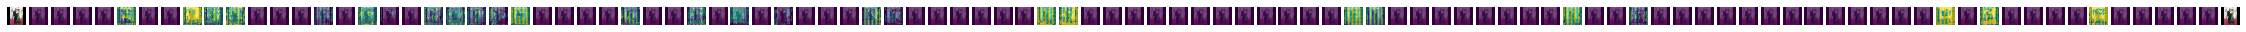

In [3]:
import train
import visualize
import argparse
import yaml
import json

%matplotlib inline
# for local run, make the notebook wider with this code
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

args = None
with open("Args/args_text.yml", 'r') as args_file:
    args_text = args_file.read()
    parser = argparse.ArgumentParser()
    cfg = yaml.safe_load(args_text)
    parser.set_defaults(**cfg)
    args = parser.parse_args([])

device = 'cpu'
main_folder_path = "../"

num_classes, train_df, test_df, categories_df = train.process_data(main_folder_path, args.data_limit)
# model = get_model_instance_segmentation(num_classes)
model = train.get_model_instance_segmentation_efficientnet(num_classes, args.target_dim, freeze_batch_norm=args.freeze_batch_norm_weights)
train_config = train.TrainConfig(args)
trainer = train.Trainer(main_folder_path, model, train_df, test_df, args.data_limit, num_classes, args.target_dim, categories_df, device, train.is_colab, config=train_config)
trainer.load_model(device)

visualize = visualize.Visualize(main_folder_path, categories_df, args.target_dim)
img_idx = 1
trainer.model.eval()
visualize.show_prediction_on_img(trainer.model, trainer.dataset_test, test_df, img_idx, train.is_colab, show_groud_truth=False, box_threshold=args.box_threshold, split_segments=True)

In [ ]:
isTPU = False
forceCPU = False
skip_pip = False

is_colab = False
try:
    from google.colab import drive
    print("Running on Google Colab")
    is_colab = True
except:
    print("Running on non Google Colab env")

if is_colab and not skip_pip:
# if True:
    # pip install
    for pkg in ['matplotlib',
                'sklearn',
                'tensorflow',     # required by by keras
                'keras',
                'pandas',
                'opencv-python',  # cv2
                'cython',         # required by pycocotools
                'omegaconf',
                'timm',           # originally was - !pip install -U timm --user
                'h5py',
                'nvidia-ml-py3'
                'cv2'
                'ipywidgets']:
        !pip install -U $pkg

    # torchvision from ofekp repo
    # I made a change in torchvision library, so it needs to be compiled from the source code
    # I could not make this work on windows, for linux (ubuntu) use this:
    # TODO(ofekp): uninstall this and see if it is needed !pip install nvidia-ml-py
    !sudo apt install build-essential --assume-yes
    # bounding box needs the following
    !sudo apt-get install ffmpeg libsm6 libxext6 -y
    # torch must be installed with cuda 10.1 since the env is set up with cuda 10.1
    # also, torch is not yes supporting cuda version > 10.1 (e.g. cuda 11)
    if not isTPU:
        # refer to https://pytorch.org/get-started/locally/ to get the command for installation without cuda
        !pip install torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
    else:
        !pip install torch

    !sudo apt install libavcodec-dev --assume-yes
    !sudo apt install libavformat-dev --assume-yes
    !sudo apt install libswscale-dev --assume-yes
    !pip install ninja
    !pip install git+https://github.com/ofekp/vision.git
        
    # effdet from ofekp repo
    !pip install git+https://github.com/ofekp/efficientdet-pytorch.git

    # Install coco_utils
    # Win10:
    #       !pip install cython
    #       now follow this guide (Exactly!): https://github.com/philferriere/cocoapi
    #       update: I fixed support for numpy > 1.17 due to error "'numpy.float64' object cannot be interpreted as an integer"
    #       to include it use my git repo "pip install git+https://github.com/ofekp/cocoapi.git#subdirectory=PythonAPI"
    #       make sure to remove the previous version before installing from my branch by using "pip uninstall pycocotools"
    #
    # Colab/Linux: 
    !pip install cython
    !pip install -U git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

    # TODO(ofekp): this is probably not needed
    # Install segmentation package
    #!pip install -U segmentation-models-pytorch albumentations --user

    # TODO(ofekp): This is not needed since I made a change and the code is now directly in the folder
    # https://github.com/nalepae/bounding-box.git
    # !pip install bounding-box
    # !git clone https://github.com/nalepae/bounding-box.git
    # !pip uninstall -y bounding-box
    
# connect to Google Drive
if is_colab:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/gdrive')
    print("Folder content:")
    main_folder_path = '/content/gdrive/Shared drives/project_200446375_204031231/'
    main_folder_path_escaped = main_folder_path.replace(" ", "\ ")
    !ls $main_folder_path_escaped
    ofek_code_folder_imports = '/content/gdrive/Shared drives/project_200446375_204031231/code_ofek/*.{py,ttf}'
    ofek_code_folder_imports = ofek_code_folder_imports.replace(" ", "\ ")
    !cp $ofek_code_folder_imports .
else:
    main_folder_path = '../'
    %matplotlib inline
    # for local run, make the notebook wider with this code
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 150)
    
if isTPU:
    import torch
    !env | grep TPU
    import torch_xla
    import torch_xla.core.xla_model as xm

    
def reload_external_packages():
    '''
    reloads the package with changes
    IMPORTANT:
        If you use this, you cannot save the model with torch.save()!
        It will cause an exception in Pickle
    '''
    if is_colab:
        ofek_code_folder_imports = '/content/gdrive/Shared drives/project_200446375_204031231/code_ofek/*.{py,ttf}'
        ofek_code_folder_imports = ofek_code_folder_imports.replace(" ", "\ ")
        !cp $ofek_code_folder_imports .
    importlib.reload(helpers)
    importlib.reload(bbx)
    importlib.reload(torch)
    importlib.reload(torchvision)
    importlib.reload(engine)
    importlib.reload(pycocotools)
    importlib.reload(coco_utils)
    importlib.reload(coco_eval)
    importlib.reload(utils)
    importlib.reload(transforms)

In [ ]:
%matplotlib inline

image_id = train_df.iloc[25]['ImageId']
# image_id = '000b3ec2c6eaffb491a5abb72c2e3e26'
# image_id = '0066d8d66ec36bdb91592fdc4aa17ed9'
# image_id = '029720c77ebda81f6a57efd7a34df406'
# image_id = 'd3602308d5894f1a6ee0632a98321ca3'
# image_id = '361cc7654672860b1b7c85fe8e92b38a'
# image_id = '0000fe7c9191fba733c8a69cfaf962b7'
# image_id = '04c0dd48d11b43bfab3a0651582dd3ad'
# image_id = '0556dd69fa22ca23e438cb8ce944fcb8'
show_image_data_ground_truth(main_folder_path, train_df, image_id)